In [9]:
import bs4
import requests
import time
import random as ran
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings('ignore')

# 1. Crawling data using BeautifulSoup package

In [10]:
url = 'https://www.imdb.com/search/title?release_date=2018&sort=boxoffice_gross_us,desc&start=1'
headers = {
    'accept-language': 'en-US,en;q=0.9'
}
source = requests.get(url, headers=headers).text
soup = bs4.BeautifulSoup(source,'html.parser')

Since above code extracts all data on the first page, below code is run only to extract movie information on it.

In [3]:
movie_blocks = soup.findAll('div',{'class':'lister-item-content'})

Before extracting information across all movies, We first examine one of the extracted block to identify the elements that we need to scrape.

Below We've extracted the elements from the first movie block

In [4]:
mname = movie_blocks[0].find('a').get_text() # Name of the movie

m_reyear = int(movie_blocks[0].find('span',{'class': 'lister-item-year'}).contents[0][1:-1]) # Release year

m_rating = float(movie_blocks[0].find('div',{'class':'inline-block ratings-imdb-rating'}).get('data-value')) #rating

m_mscore = float(movie_blocks[0].find('span',{'class':'metascore favorable'}).contents[0].strip()) #meta score

m_votes = int(movie_blocks[0].find_all('span',{'name':'nv'})[0].get('data-value')) # votes

m_gross = movie_blocks[0].find_all('span',{'name':'nv'})[1].get('data-value') # votes
m_gross = int(m_gross.replace(',', ''))

print("Movie Name: " + mname,
      "\nRelease Year: " + str(m_reyear),
      "\nIMDb Rating: " + str(m_rating),
      "\nMeta score: " + str(m_mscore),
      "\nVotes: " + '{:,}'.format(m_votes),
      "\nGross: " + '{:,}'.format(m_gross)

)

Movie Name: Black Panther 
Release Year: 2018 
IMDb Rating: 7.3 
Meta score: 88.0 
Votes: 723,327 
Gross: 700,059,566


Once we examined the resulting pages of the IMDB search that we initially did , it's obvious that by editing the html link it is possible to view all search results. Thus we will be using this feature during the scrape to iterate through all pages.

Now since scraping the data is an iterative process, We define separate functions for each purpose.

First we are going to define a function which will extract the targeted elements from a 'movie block list' (discussed above)

In [5]:
def scrape_mblock(movie_block):
    
    movieb_data ={}
  
    try:
        movieb_data['name'] = movie_block.find('a').get_text() # Name of the movie
    except:
        movieb_data['name'] = None

    try:    
        year =  str(movie_block.find('span',{'class': 'lister-item-year'}).contents[0][1:-1]) # Release year   
        tmp_year = [int(s) for s in re.findall(r'\b\d+\b', year)]     
        movieb_data['year'] = tmp_year[0]
    except:
        movieb_data['year'] = None

    try:
        rating = movie_block.find('div',{'class':'inline-block ratings-imdb-rating'}).get('data-value') #rating
        movieb_data['rating'] = float(rating.replace(',', ''))
    except:
        movieb_data['rating'] = None

    try:
        m_score = movie_block.find('span',{'class':'metascore favorable'}).contents[0].strip() #meta score
        movieb_data['m_score'] = float(m_score.replace(',', ''))
    except:
      try:
          m_score = movie_block.find('span',{'class':'metascore mixed'}).contents[0].strip() #meta score
          movieb_data['m_score'] = float(m_score.replace(',', ''))
      except:
        try:
          m_score = movie_block.find('span',{'class':'metascore unfavorable'}).contents[0].strip() #meta score
          movieb_data['m_score'] = float(m_score.replace(',', ''))
        except:
          movieb_data['m_score'] = None


    try:    
        runtime = str(movie_block.find('span',{'class': 'runtime'}).contents[0][:-3])
        movieb_data['runtime'] = int(runtime)
    except:
        movieb_data['runtime'] = None

    try:
        m_votes = movie_block.find_all('span',{'name':'nv'})[0].get('data-value') # votes
        movieb_data['votes'] = int(m_votes.replace(',', ''))
    except:
        movieb_data['votes'] = None

    try:
        m_gross = movie_block.find_all('span',{'name':'nv'})[1].get('data-value') # gross
        movieb_data['gross'] = int(m_gross.replace(',', ''))
    except:
        movieb_data['gross'] = None

    return movieb_data
    

Then we create the function below to scrape all movie blocks within a single search result page

In [6]:
def scrape_m_page(movie_blocks):
    
    page_movie_data = []
    num_blocks = len(movie_blocks)
    
    for block in range(num_blocks):
        page_movie_data.append(scrape_mblock(movie_blocks[block]))
    
    return page_movie_data

Now we built functions to extract all movie data from a single page.

Next function will be created to iterate the above made function through all pages of the search result untill we scrape data for the targeted number of movies

In [7]:
def scrape_this(link,t_count):
    
    #from IPython.core.debugger import set_trace

    base_url = link
    target = t_count
    
    current_mcount_start = 0
    current_mcount_end = 0
    remaining_mcount = target - current_mcount_end 
    
    new_page_number = 1
    
    movie_data = []
    
    
    while remaining_mcount > 0:

        url = base_url + str(new_page_number)
        
        #set_trace()
        
        source = requests.get(url, headers = headers).text
        soup = bs4.BeautifulSoup(source,'html.parser')
        
        movie_blocks = soup.findAll('div',{'class':'lister-item-content'})
        
        movie_data.extend(scrape_m_page(movie_blocks))   
        
        current_mcount_start = soup.find("div", {"class":"nav"}).find("div", {"class": "desc"}).contents[1].get_text().split("-")[0]
        current_mcount_start = int(current_mcount_start.replace(',', ''))

        current_mcount_end = soup.find("div", {"class":"nav"}).find("div", {"class": "desc"}).contents[1].get_text().split("-")[1].split(" ")[0]
        current_mcount_end = int(current_mcount_end.replace(',', ''))

        remaining_mcount = target - current_mcount_end
        
        print('\r' + "currently scraping movies from: " + str(current_mcount_start) + " - "+str(current_mcount_end), "| remaining count: " + str(remaining_mcount), flush=True, end ="")
        
        new_page_number = current_mcount_end + 1
        
        time.sleep(ran.randint(0, 3))
    
    return movie_data
    
    

In [8]:
from os.path import exists
if exists('data.csv'):
    df = pd.read_csv('data.csv')
else:
    base_scraping_link = "https://www.imdb.com/search/title?release_date=2017-01-01,2022-3-31&sort=boxoffice_gross_us,desc&start="

    top_movies = 10000 #input("How many movies do you want to scrape?")
    films = []

    films = scrape_this(base_scraping_link,int(top_movies))

    print('\r'+"List of top " + str(top_movies) +" movies:" + "\n", end="\n")
    df = pd.DataFrame(films)
    df.to_csv('data.csv')

We are organizing the final results as a dataframe with below elements:

* `name` - title of the movie, 
* `year` - release year of the movie, 
* `rating` - rating of movies,
* `m_score` - meta score of the movie, 
* `runtime` - runtime of the movie, 
* `vote` - number of votes,
* `gross` - gross of movies.

In [31]:
df

,Unnamed: 0,name,year,rating,m_score,runtime,votes,gross
0,0,Avengers: Endgame,2019.0,8.4,78.0,181.0,1051980.0,858373000.0
1,1,Black Panther,2018.0,7.3,88.0,134.0,722189.0,700059566.0
2,2,Avengers: Infinity War,2018.0,8.4,68.0,149.0,1014447.0,678815482.0
3,3,Star Wars: Episode VIII - The Last Jedi,2017.0,6.9,84.0,152.0,612003.0,620181382.0
4,4,Incredibles 2,2018.0,7.6,80.0,118.0,285517.0,608581744.0
...,...,...,...,...,...,...,...,...
9994,9994,Sou Amor,2018.0,NaN,NaN,NaN,NaN,NaN
9995,9995,Plus belle la vie,2004.0,NaN,NaN,89.0,NaN,NaN
9996,9996,And Then This Happened,2017.0,NaN,NaN,NaN,NaN,NaN
9997,9997,Sou Amor,2018.0,NaN,NaN,NaN,NaN,NaN


# 2. Pre-processing

## Remove null values

In [21]:
df2 =df.dropna()
df2

,Unnamed: 0,name,year,rating,m_score,runtime,votes,gross
0,0,Avengers: Endgame,2019.0,8.4,78.0,181.0,1051980.0,858373000.0
1,1,Black Panther,2018.0,7.3,88.0,134.0,722189.0,700059566.0
2,2,Avengers: Infinity War,2018.0,8.4,68.0,149.0,1014447.0,678815482.0
3,3,Star Wars: Episode VIII - The Last Jedi,2017.0,6.9,84.0,152.0,612003.0,620181382.0
4,4,Incredibles 2,2018.0,7.6,80.0,118.0,285517.0,608581744.0
...,...,...,...,...,...,...,...,...
1669,1669,West Of The Jordan River,2017.0,6.7,56.0,84.0,83.0,1926.0
1679,1679,Marrowbone,2017.0,6.6,63.0,110.0,30311.0,1377.0
1684,1684,Invisible Hands,2018.0,8.1,81.0,80.0,46.0,1034.0
1689,1689,The Swan,2017.0,6.4,58.0,91.0,403.0,898.0


In [22]:
import numpy as np
from scipy import stats
df1 = df2[['year', 'rating', 'm_score', 'runtime', 'votes', 'gross']]
df1 = df1[(np.abs(stats.zscore(df1)) < 2).all(axis=1)]
df1

,year,rating,m_score,runtime,votes,gross
46,2017.0,7.3,75.0,104.0,146555.0,175750384.0
47,2019.0,6.8,81.0,116.0,275258.0,175084580.0
48,2017.0,6.3,50.0,97.0,123137.0,175003033.0
49,2018.0,6.9,74.0,120.0,166511.0,174532921.0
50,2017.0,7.5,48.0,105.0,272177.0,174340174.0
...,...,...,...,...,...,...
1668,2017.0,6.0,71.0,81.0,266.0,2027.0
1669,2017.0,6.7,56.0,84.0,83.0,1926.0
1679,2017.0,6.6,63.0,110.0,30311.0,1377.0
1684,2018.0,8.1,81.0,80.0,46.0,1034.0


## Remove invalid rows

In [12]:
# get unique years
df1['year'].unique()

array([2017., 2019., 2018., 2020.])

In [13]:
# remove invalid year data
df1 = df1[df1['year'] != 1985]
df1['year'].unique()

array([2017., 2019., 2018., 2020.])

# 3. EDA

In [14]:
df1.describe()

,year,rating,m_score,runtime,votes,gross
count,985.000000,985.000000,985.000000,985.000000,985.000000,9.850000e+02
mean,2017.757360,6.567513,63.233503,104.206091,33404.280203,1.544994e+07
std,0.759097,0.688864,14.535012,15.499448,56139.029419,3.213415e+07
min,2017.000000,4.900000,30.000000,60.000000,14.000000,8.980000e+02
25%,2017.000000,6.100000,53.000000,93.000000,1670.000000,5.752800e+04
50%,2018.000000,6.600000,65.000000,102.000000,7341.000000,5.133810e+05
75%,2018.000000,7.100000,74.000000,113.000000,37071.000000,1.398512e+07
max,2020.000000,8.100000,94.000000,155.000000,297582.000000,1.757504e+08


In [15]:
dfx = df1.groupby('year').mean()
print(len(dfx))

4


In [16]:
df10 = dfx.nlargest(5, 'gross')
df10

,rating,m_score,runtime,votes,gross
year,,,,,
2020.0,6.430769,57.692308,110.615385,107969.615385,5.340197e+07
2019.0,6.547403,59.500000,105.500000,50438.227273,2.811506e+07
2018.0,6.533333,63.611529,104.716792,28513.689223,1.384107e+07
2017.0,6.611695,64.417661,103.045346,29487.260143,1.114955e+07


## Average gross by the year

<AxesSubplot:xlabel='year'>

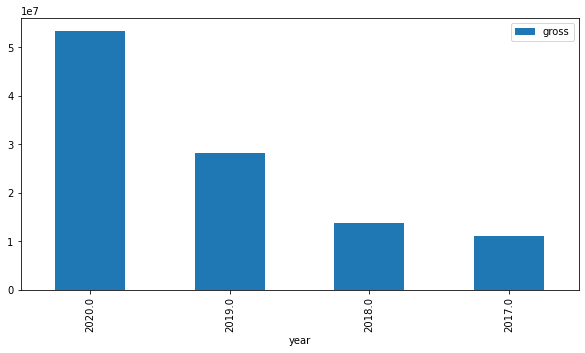

In [17]:
# average grosss by year
df10[['gross']].plot.bar(figsize=(10, 5))

## Average ratings by the year

<AxesSubplot:xlabel='year'>

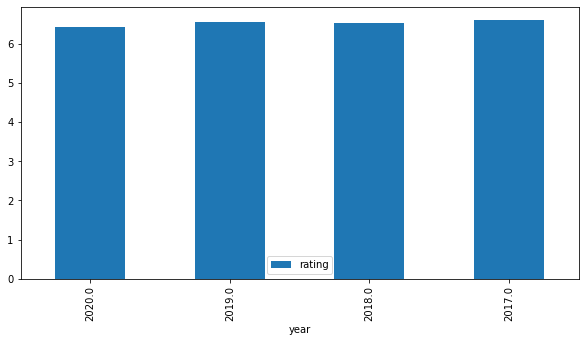

In [18]:
# average rating by year
df10[['rating']].plot.bar(figsize=(10, 5))

## Average votes by the year

<AxesSubplot:xlabel='year'>

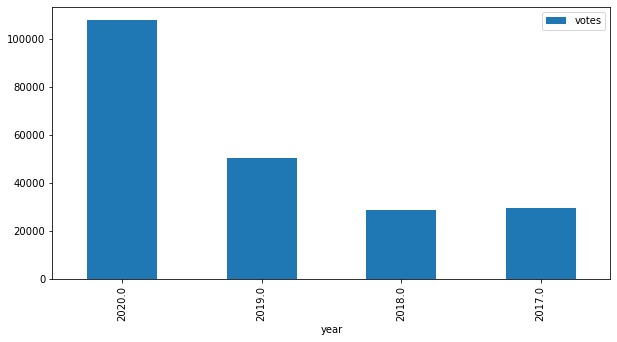

In [19]:
# average votes by year
df10[['votes']].plot.bar(figsize=(10, 5))

In [20]:
df1 =  df1[['year', 'rating', 'm_score', 'runtime', 'votes', 'gross']]
corr = df1.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,year,rating,m_score,runtime,votes,gross
year,1.00,-0.05,-0.11,0.07,0.15,0.20
rating,-0.05,1.00,0.59,0.11,0.09,-0.05
m_score,-0.11,0.59,1.00,-0.02,-0.05,-0.21
runtime,0.07,0.11,-0.02,1.00,0.35,0.19
votes,0.15,0.09,-0.05,0.35,1.00,0.68
gross,0.20,-0.05,-0.21,0.19,0.68,1.00


# 4. Regression Models

As we are going to predict the coninuous variables So we will use regression models.

In [21]:
X = df1[['year', 'm_score','runtime', 'votes']]
y = df1['gross']

# Train Regression models
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()

reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)

ereg = VotingRegressor([("gb", reg1), ("rf", reg2), ("lr", reg3)])
ereg.fit(X, y)

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=1)),
                            ('rf', RandomForestRegressor(random_state=1)),
                            ('lr', LinearRegression())])

In [22]:
# Predict gross using trained regression models
pred1 = reg1.predict(X)
pred2 = reg2.predict(X)
pred3 = reg3.predict(X)
pred4 = ereg.predict(X)

In [23]:
y-pred2

46      47464418.40
47      46813236.39
48      39906855.05
49      48653864.67
50      27489615.02
           ...     
1668      -20403.83
1669       -4072.25
1679    -4641810.69
1684      -32950.67
1689      -10014.49
Name: gross, Length: 985, dtype: float64

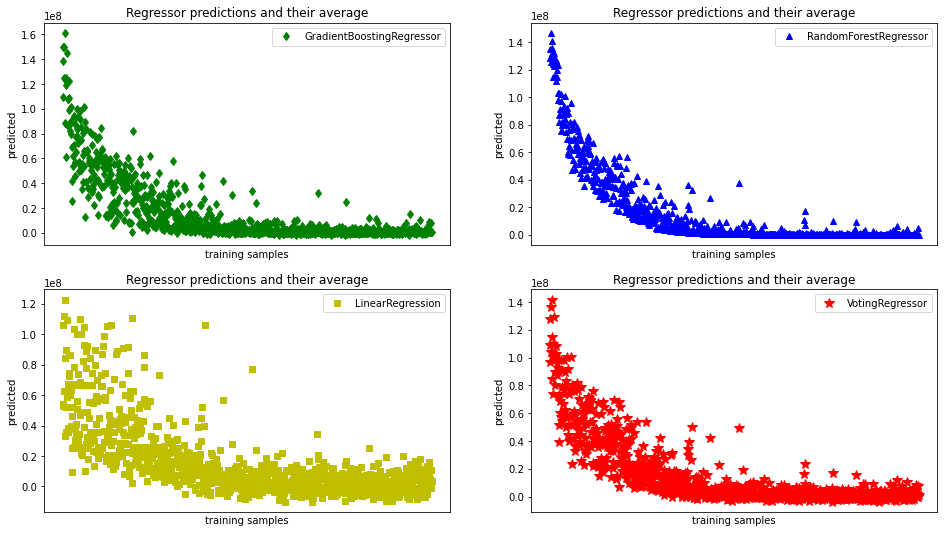

In [24]:
fig, axs = plt.subplots(2,2,figsize=(16,9), gridspec_kw={'height_ratios': [1, 1]})

axs[0, 0].plot(pred1, "gd", label="GradientBoostingRegressor")
axs[0, 0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
axs[0, 0].set_ylabel("predicted")
axs[0, 0].set_xlabel("training samples")
axs[0, 0].legend(loc="best")
axs[0, 0].set_title("Regressor predictions and their average")

axs[0, 1].plot(pred2, "b^", label="RandomForestRegressor")
axs[0, 1].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
axs[0, 1].set_ylabel("predicted")
axs[0, 1].set_xlabel("training samples")
axs[0, 1].legend(loc="best")
axs[0, 1].set_title("Regressor predictions and their average")

axs[1, 0].plot(pred3, "ys", label="LinearRegression")
axs[1, 0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
axs[1, 0].set_ylabel("predicted")
axs[1, 0].set_xlabel("training samples")
axs[1, 0].legend(loc="best")
axs[1, 0].set_title("Regressor predictions and their average")

axs[1, 1].plot(pred4, "r*", ms=10, label="VotingRegressor")
axs[1, 1].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
axs[1, 1].set_ylabel("predicted")
axs[1, 1].set_xlabel("training samples")
axs[1, 1].legend(loc="best")
axs[1, 1].set_title("Regressor predictions and their average")

plt.show()

In [25]:
Pred_df = pd.DataFrame({'Actual': y,'GB': pred1.astype(int), 'RF':pred2.astype(int), 'LR': pred3.astype(int), 'VR': pred4.astype(int)})
Pred_df.head(10)

,Actual,GB,RF,LR,VR
46,175750384.0,109511171,128285965,52657035,96818057
47,175084580.0,149640511,128271343,106206482,128039445
48,175003033.0,138919823,135096177,53933396,109316466
49,174532921.0,124662581,125879056,62440624,104327420
50,174340174.0,149578765,146850558,112153569,136194298
51,173956935.0,124442671,135797588,84613894,114951384
53,172558876.0,161429163,141025442,122819302,141757969
54,171958438.0,88184386,132362538,33087431,84544785
57,167510016.0,61329950,124142810,35507450,73660070
61,160799505.0,119172128,129573383,51939185,100228232


In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = []
rmse.append(mean_squared_error(Pred_df['Actual'], Pred_df['GB'], squared=False))
rmse.append(mean_squared_error(Pred_df['Actual'], Pred_df['RF'], squared=False))
rmse.append(mean_squared_error(Pred_df['Actual'], Pred_df['LR'], squared=False))
rmse.append(mean_squared_error(Pred_df['Actual'], Pred_df['VR'], squared=False))
rmse

methods = ['GradientBoostingRegressor', 'RandomForestRegressor', 'LinearRegression', 'VotingRegressor']
RMSE = pd.DataFrame({'Method': methods,'RMSE': rmse})
RMSE

,Method,RMSE
0,GradientBoostingRegressor,1.414239e+07
1,RandomForestRegressor,8.707738e+06
2,LinearRegression,2.245879e+07
3,VotingRegressor,1.449334e+07


<AxesSubplot:xlabel='Method'>

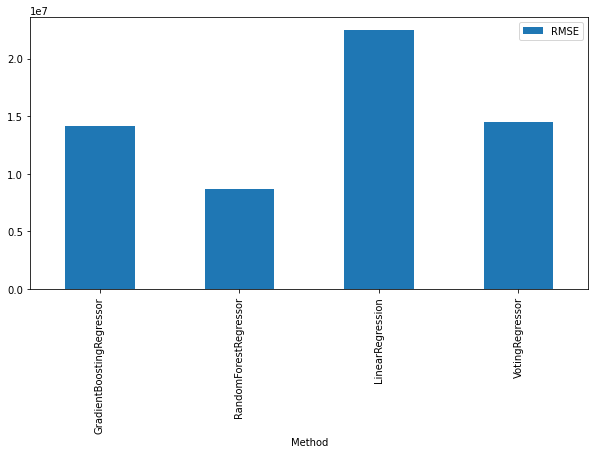

In [27]:
RMSE.plot.bar(x = 'Method', y = 'RMSE', figsize=(10, 5))

From above table and graph, we can see that Random Forest Regressor is the best. Now let predict gross for all values.

# Predict the gross using other features

In [28]:
df1.head()

,year,rating,m_score,runtime,votes,gross
46,2017.0,7.3,75.0,104.0,146555.0,175750384.0
47,2019.0,6.8,81.0,116.0,275258.0,175084580.0
48,2017.0,6.3,50.0,97.0,123137.0,175003033.0
49,2018.0,6.9,74.0,120.0,166511.0,174532921.0
50,2017.0,7.5,48.0,105.0,272177.0,174340174.0


In [29]:
pred_gross = reg1.predict(X)
df1['pred_gross'] = pred_gross.astype(int)
df1['error(%)'] = abs(df1['gross'] - df1['pred_gross'])/df1['gross'] * 100
df1 = df1[df1['error(%)'] < 10]
df1 =df1.reset_index(drop=True)
df1.head(20)

,year,rating,m_score,runtime,votes,gross,pred_gross,error(%)
0,2017.0,6.5,39.0,129.0,297582.0,172558876.0,161429163,6.449806
1,2018.0,6.5,52.0,134.0,268094.0,159555901.0,145284252,8.944607
2,2017.0,6.5,52.0,114.0,247997.0,102826543.0,100078806,2.672206
3,2018.0,6.1,45.0,107.0,162719.0,101028233.0,93730401,7.223557
4,2019.0,7.3,69.0,121.0,169226.0,96368160.0,92091422,4.437916
5,2020.0,6.0,60.0,109.0,228537.0,84158461.0,85558529,1.663609
6,2019.0,5.6,38.0,114.0,130652.0,80001807.0,80894958,1.116414
7,2020.0,7.1,72.0,124.0,216635.0,70410000.0,66127390,6.082389
8,2018.0,5.2,54.0,97.0,62854.0,69488745.0,64904259,6.597451
9,2018.0,6.9,66.0,100.0,229388.0,69179066.0,66371178,4.058869
